# Application for the Journal of Open Aviation Science

This document has been published for reproducing the application presented in a software paper dedicated to AeroMAPS, published in [Journal of Open Aviation Science](https://journals.open.tudelft.nl/joas/index). The different assumptions of this prospective scenario are given in the following. 

An illustrative 2% annual air traffic growth is assumed for the different aviation markets, i.e. lower than trend estimates of around 3%. The impact of COVID-19 is modelled assuming that air traffic returns to 2019 levels in 2024. Concerning the aircraft fleet, an accelerated fleet renewal is assumed with the introduction of 20% more efficient aircraft architectures in 2035. A hydrogen-powered aircraft is more specifically considered for short-range. Operational improvements are also included for reducing fuel consumption, but operational strategies for contrail avoidance are not considered here, even though it is a promising approach. Regarding the replacement of kerosene by drop-in fuels (biofuel and electrofuel here), ReFuelEU targets are considered as blending mandates. Different pathways are considered for the production of biofuel and hydrogen. Electricity production is expected to decarbonise rapidly and strongly, so that CO<sub>2</sub> emissions from electricity-based fuels will be lower than those from kerosene by 2035. On the economic side, several assumptions are made such as median fuel costs or a constant electricity price of 80 €/MWh. Moreover, a carbon price trajectory, based on *Alain Quinet, What Value Do We Attach to Climate Action?, 2019*, is implemented in the form of a tax on the emissions of fossil and alternative fuels.

Moreover, in order to carry out a sustainability assessment, some assumptions are required for setting targets for aviation. A climate target of +1.8°C with a 67% chance of success is chosen as well as a moderate use of Carbon Dioxide Removal (CDR) worldwide. Median estimations are considered for biomass and electricity availability. Finally, concerning allocation rules, a grandfathering approach is assumed for climate issues, which means that 2.6% (i.e. aviation's current share of CO<sub>2</sub> emissions) of the world carbon budget is allocated for aviation. For energy resources, an illustrative and arbitrary allocation of 5% is assumed.

## Load and process

In [1]:
%matplotlib widget
import time
import numpy as np
from aeromaps.core.process import create_process
from aeromaps.core.models import models_complex
from aeromaps.models.air_transport.aircraft_fleet_and_operations.fleet.fleet_model import (
    Fleet,
    AircraftParameters,
    Aircraft,
    SubCategory,
    SubcategoryParameters
)

In [2]:
process = create_process(
    models=models_complex,
    use_fleet_model=True,
    add_examples_aircraft_and_subcategory=False,
)

In [3]:
# Change end year
process.parameters.end_year = 2070
process.setup(add_examples_aircraft_and_subcategory=False)

## Set up variables

### Aviation scenario

In [4]:
# Air traffic evolution

## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [2.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [2.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [2.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [2.0]

In [5]:
# Aircraft fleet

## Initialization
fleet = process.fleet

## Subcat
total_value = 14
if total_value<27:
    total_value_short = total_value/25*100
    total_value_medium = 0
elif total_value<27+35:
    total_value_short = 100
    total_value_medium = (total_value-27)/35*100
fleet.categories["Short Range"].subcategories[0].parameters.share = 100-total_value_short
sr_subcat = SubCategory("SR new subcategory", parameters=SubcategoryParameters(share=total_value_short))
fleet.categories["Short Range"].add_subcategory(subcategory=sr_subcat)
## Subcat
fleet.categories["Medium Range"].subcategories[0].parameters.share = 100-total_value_medium
mr_subcat = SubCategory("MR new subcategory", parameters=SubcategoryParameters(share=total_value_medium))
fleet.categories["Medium Range"].add_subcategory(subcategory=mr_subcat)

## Basic Short Range
short_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-20.0,
    nox_evolution=-75.0,
    soot_evolution=-100.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.25,
)
short_range_aircraft = Aircraft(
    "New Short-range Aircraft - Conventional",
    parameters=short_range_aircraft_params,
    energy_type="DROP_IN_FUEL",
)
fleet.categories["Short Range"].subcategories[0].add_aircraft(aircraft=short_range_aircraft)

## New Short Range
short_range_aircraft_new_params = AircraftParameters(
    entry_into_service_year=2040,
    consumption_evolution=20.0,
    nox_evolution=-50.0,
    soot_evolution=-50.0,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.25,
)
short_range_aircraft_new = Aircraft(
    "New Short-range Aircraft - New type",
    parameters=short_range_aircraft_new_params,
    energy_type="HYDROGEN",
)
fleet.categories["Short Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)


## Medium Range
medium_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.25,
)
medium_range_aircraft = Aircraft(
    "New Medium-range Aircraft", parameters=medium_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Medium Range"].subcategories[0].add_aircraft(aircraft=medium_range_aircraft)

## New Medium Range
medium_range_aircraft_new_params = AircraftParameters(
    entry_into_service_year=2040,
    consumption_evolution=20.0,
    nox_evolution=-50.0,
    soot_evolution=-50.0,
    doc_non_energy_evolution=10.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.25,
)
medium_range_aircraft_new = Aircraft(
    "New Medium-range Aircraft - New type",
    parameters=medium_range_aircraft_new_params,
    energy_type="HYDROGEN",
)
fleet.categories["Medium Range"].subcategories[1].add_aircraft(aircraft=short_range_aircraft_new)

## Long Range
long_range_aircraft_params = AircraftParameters(
    entry_into_service_year=2035,
    consumption_evolution=-20.0,
    nox_evolution=0.0,
    soot_evolution=0.0,
    doc_non_energy_evolution=0.0,
    cruise_altitude=12000.0,
    hybridization_factor=0.25,
)
long_range_aircraft = Aircraft(
    "New Long-range Aircraft", parameters=long_range_aircraft_params, energy_type="DROP_IN_FUEL"
)
fleet.categories["Long Range"].subcategories[0].add_aircraft(aircraft=long_range_aircraft)

## Fleet renewal
fleet.categories["Short Range"].parameters.life = 20
fleet.categories["Medium Range"].parameters.life = 20
fleet.categories["Long Range"].parameters.life = 20

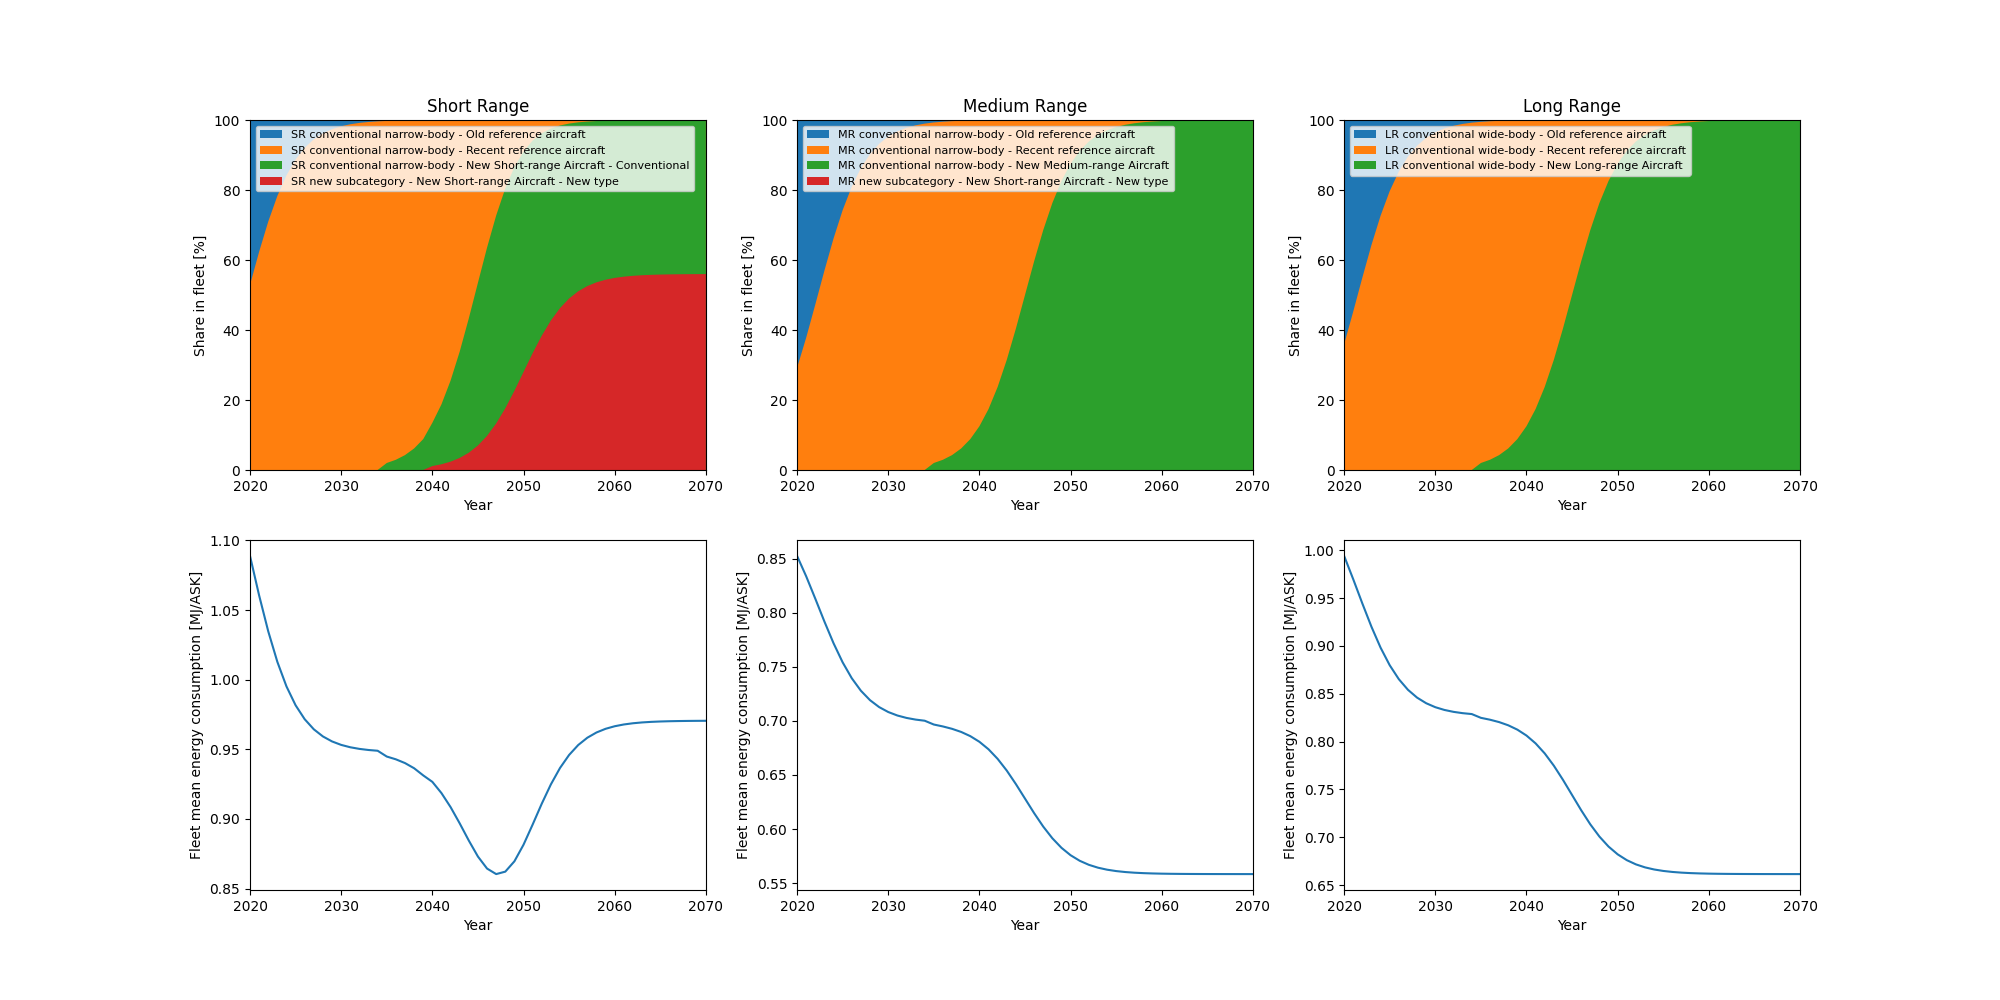

In [6]:
fleet_model = process.fleet_model
process.setup(add_examples_aircraft_and_subcategory=False)
fleet_model.compute()
fleet_model.plot()

In [7]:
# Aircraft fleet and operation evolution - Aircraft load factor

## Aircraft load factor in 2050 [%]
process.parameters.load_factor_end_year = 89  # 2019 value: 82.399312

In [8]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

In [9]:
# Aircraft energy - Introduction of alternative drop-in fuels

## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = []
process.parameters.biofuel_share_reference_years_values = [0.0]
process.parameters.electrofuel_share_reference_years = []
process.parameters.electrofuel_share_reference_years_values = [0.0]

In [10]:
# Various environmental settings

## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_hefa_fog_share_reference_years_values = [100, 0.7, 0.7, 0.7]
process.parameters.biofuel_hefa_others_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_hefa_others_share_reference_years_values = [0.0, 3.8, 3.8, 3.8]
process.parameters.biofuel_ft_others_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_ft_others_share_reference_years_values = [0.0, 76.3, 76.3, 76.3]
process.parameters.biofuel_ft_msw_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.biofuel_ft_msw_share_reference_years_values = [0.0, 7.4, 7.4, 7.4]

## Emission factors for electricity (2019 value: 429 gCO2/kWh)
process.parameters.electricity_emission_factor_reference_years = []
process.parameters.electricity_emission_factor_reference_years_values = [10.0]

## Share of hydrogen production pathways (the rest being completed by production via coal without CCS) [%]
## Distribution in 2019: Gas without CCS (71%), Coal without CCS (27%), Electrolysis (2%), Others with CCS (0%), Co-products not taken into account
process.parameters.hydrogen_electrolysis_share_reference_years = []
process.parameters.hydrogen_electrolysis_share_reference_years_values = [100]
process.parameters.hydrogen_gas_ccs_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_gas_ccs_share_reference_years_values = [0, 0, 0, 0]
process.parameters.hydrogen_coal_ccs_share_reference_years = [2020, 2030, 2040, 2050]
process.parameters.hydrogen_coal_ccs_share_reference_years_values = [0, 0, 0, 0]
process.parameters.hydrogen_gas_share_reference_years = []
process.parameters.hydrogen_gas_share_reference_years_values = [0]

## Compute

In [11]:
t1 = time.time()
process.compute()
t2 = time.time()
print("Computation time:", np.round(t2 - t1, 2), "s")

/Users/s.delbecq/PycharmProjects/AeroMAPS/aeromaps/models/base.py:73: UserWarning: Warning Message - Model name: biofuel_production - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
/Users/s.delbecq/PycharmProjects/AeroMAPS/aeromaps/models/base.py:73: UserWarning: Warning Message - Model name: biofuel_production - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to the last reference year is therefore used as a constant for the upper years.
  warnings.warn(
/Users/s.delbecq/PycharmProjects/AeroMAPS/aeromaps/models/base.py:73: UserWarning: Warning Message - Model name: biofuel_production - Warning on AeromapsInterpolationFunction: The last reference year for the interpolation is lower than end_year, the value associated to th

Computation time: 1.21 s


## Results

### Main results

In [12]:
print(
    "CO2 emissions in 2050:",
    round(process.data["climate_outputs"]["co2_emissions"][2050], 0),
    "MtCO2",
)
print(
    "Cumulative CO2 emissions between 2020 and 2050:",
    round(process.data["vector_outputs"]["cumulative_co2_emissions"][2050], 1),
    "GtCO2",
)
print(
    "Energy consumption in 2050:",
    round(process.data["vector_outputs"]["energy_consumption"][2050]/10**12, 1),
    "EJ",
)

CO2 emissions in 2050: 1307.0 MtCO2
Cumulative CO2 emissions between 2020 and 2050: 32.2 GtCO2
Energy consumption in 2050: 14.7 EJ


### Plots

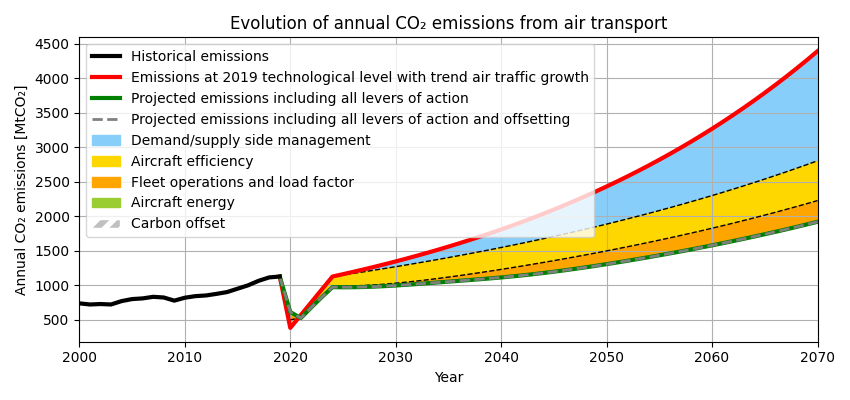

In [13]:
process.plot("air_transport_co2_emissions")